# How to use `mobair` to compute emissions
This is a small example illustrating how to use the methods in the library to estimate and visualize the emissions of a set of vehicles starting from their GPS trajectories.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox  # version '0.16.0' or greater
import mobair as mb

### Loading input files...

- `modelli_auto` contains the vehicles' information from which the `fuel_type` will be extracted;
- `emission_functions` contains the values for the emission functions
- `max_interval` is the maximum time interval (in seconds) that one wants between each pair of points in the trajectories;
- `region` is just the name of the region for which the road network is needed;

In [3]:
###### Parameters:
path_to_table_with_info_on_vehicles = './data/private/modelli_auto.tar.xz'
path_to_table_with_emission_functions = './data/private/emission_functions.csv'
max_interval = 120
region = 'Rome'
######

#### Loading a little tdf from ./data

- `some_trajectories_in_Rome.json` is a `TrajDataFrame` with a little sample of trajectories of some vehicles moving in the center of Rome;

In [4]:
path_to_input_file = './data/private/some_trajectories_in_Rome.json'
tdf = skmob.read(path_to_input_file)

print("Num of selected trajectories ('tid'):", len(set(tdf['tid'])))
set_of_uid_in_input = set(tdf['uid'])
num_of_uid_in_input = len(set_of_uid_in_input)
print("Num of vehicles ('uid'):", num_of_uid_in_input)
tdf.drop(['tile_ID'], axis=1).head(1)  # (dropping column 'tileID', not needed here)

Num of selected trajectories ('tid'): 1087
Num of vehicles ('uid'): 68


,uid,tid,lat,lng,datetime
122384,116559,109,41.889132,12.491207,2017-02-19 16:12:02


### 1. Filtering on time
this retains only sub-trajectories composed by points that are distant not more than `max_interval` (in seconds) from each other;

In [5]:
from mobair import filtering

tdf_filtered_time = filtering.filter_on_time_interval(tdf, max_interval)

### 2. Computing speed and acceleration in each point

In [44]:
from mobair import speed

tdf_with_speed_and_acc = speed.compute_acceleration_from_tdf(tdf_filtered_time)

### 3. Filtering on speed and acceleration
this retains only points that have a value of acceleration not greater than $\pm10$ $m/s^2$, and speed $<300$ $km/h$;

In [45]:
ftdf = tdf_with_speed_and_acc[(tdf_with_speed_and_acc['acceleration'] < 10) &
                              (tdf_with_speed_and_acc['acceleration'] > -10) &
                              (tdf_with_speed_and_acc['speed'] < 300)]

In [46]:
set_of_uid_final = set(ftdf['uid'])
num_of_uid_final = len(set_of_uid_final)
print('There have been', num_of_uid_in_input-num_of_uid_final, "'uid' lost in the filtering process.")
print('Total number of uids:', ftdf.uid.unique().shape[0])

There have been 51 'uid' lost in the filtering process.
Total number of uids: 17


### 4. Loading the road network...

In [9]:
''' (This takes a bit longer...)
region_name = region.lower().replace(" ", "_")
road_network = ox.graph_from_place(region, network_type = 'drive_service')
'''

# Taking a little road network centered in Piazza Venezia, Rome:
road_network_directed = ox.graph_from_point((41.895947, 12.483000), dist=1500, network_type = 'drive_service') # Roma (centered on Piazza Venezia)

# Taking the undirected version of the network:
road_network = ox.get_undirected(road_network_directed)

### 5. Map-matching

In [47]:
from mobair import mapmatching

ftdf_final = mapmatching.find_nearest_edges_in_network(road_network, ftdf, return_tdf_with_new_col=True)
ftdf_final.head(1)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link
0,21495,109,41.887538,12.481781,2017-06-23 05:03:29,1448,0.0,0.0,"(247287881, 1380954832, 0)"


### 6. Computing emissions

- loading information on fuel types and emission functions:

In [14]:
from mobair import emissions
import tarfile
import pandas as pd

tar = tarfile.open(path_to_table_with_info_on_vehicles, "r:xz")
for x in tar.getmembers():
    file = tar.extractfile(x)
    modelli_auto = pd.read_csv(file, names=['vid', 'manufacturer', 'type'], usecols = [0,1,2])

modelli_auto.head(2)

,vid,manufacturer,type
0,1,PEUGEOT,106 106 954I CAT 3 PORTE XN
1,2,FIAT,SEICENTO SEICENTO


In [15]:
df_emissions = pd.read_csv(path_to_table_with_emission_functions)

- from modelli_auto, selecting only the vehicles that are in our filtered tdf:

In [48]:
df_vehicles_info = modelli_auto.loc[modelli_auto['vid'].isin(set_of_uid_final)]

- matching each of the selected vehicle with its fuel type:

In [49]:
dict_vehicle_fuel_type = emissions.match_vehicle_to_fuel_type(ftdf_final, modelli_auto, ['PETROL', 'DIESEL', 'LPG'])

- finally computing emissions:

In [50]:
tdf_with_emissions = emissions.compute_emissions(ftdf_final, df_emissions, dict_vehicle_fuel_type)
tdf_with_emissions.head(1)

,uid,tid,lat,lng,datetime,tile_ID,speed,acceleration,road_link,VOC,NO_x,PM,CO_2
0,21495,109,41.887538,12.481781,2017-06-23 05:03:29,1448,0.0,0.0,"(247287881, 1380954832, 0)",0.00447,0.000619,0.0,0.553


### Plotting the emissions
We can visualize the aggregated emissions on each of the road in the road network.

In [20]:
import warnings
warnings.filterwarnings('ignore')

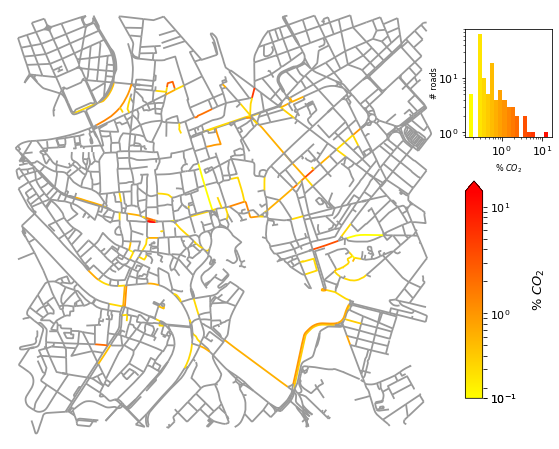

In [51]:
from mobair import plot
place = 'Rome (city center)'
fig, ax = plot.plot_road_network_with_attribute(road_network, attribute_name='CO_2', region_name=place, 
                                                tdf_with_emissions=tdf_with_emissions,
                                                normalization_factor='tot_emissions',
                                                fig_size=(8, 8), 
                                                show_hist=True, n_bins=20, log_normalise=True,
                                                color_map='autumn_r', bounding_box=None,
                                                save_fig=False)

### Plotting elevations and streets grades
Thanks to ```osmnx```, we can compute elevations of each node in the graph, and use it to compute the slope of each road, and then use ```mobair``` to plot them.

In [29]:
from keys import airmap_api_key  # change with your own api key
ox.utils.config(elevation_provider = 'airmap')  # can be either “google” or “airmap”

# add elevation to each of the nodes, using the airmap elevation API, then calculate edge grades
road_network_with_node_elev = ox.add_node_elevations(road_network, api_key=airmap_api_key)
road_network_with_elevs = ox.add_edge_grades(road_network_with_node_elev)

In [30]:
import numpy as np

place = 'Rome (city center)'
edge_grades = [data['grade_abs'] for u, v, k, data in road_network_with_elevs.edges(keys=True, data=True)]

avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in Rome (city center) is 5.9%
Median street grade in Rome (city center) is 3.8%


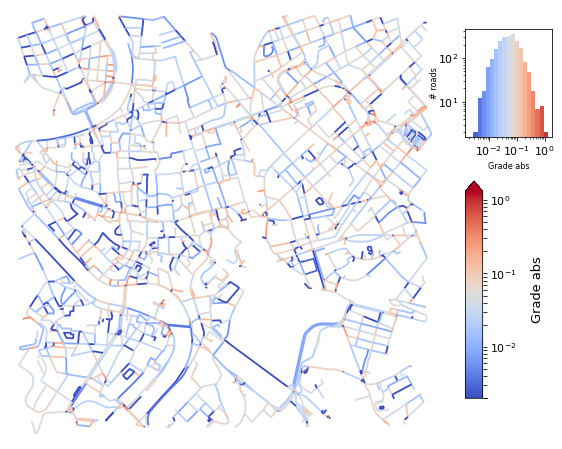

In [35]:
from mobair import plot

fig, ax = plot.plot_road_network_with_attribute(road_network_with_elevs, attribute_name='grade_abs', 
                                                region_name=place, 
                                                tdf_with_emissions=None,
                                                normalization_factor=None,
                                                fig_size=(8, 8), 
                                                show_hist=True, n_bins=20, log_normalise=True,
                                                color_map='coolwarm', bounding_box=None,
                                                save_fig=False)

### Plotting travel time
We can also compute travel times in each road, always using ```osmnx```, and plot them with ```mobair```.

In [36]:
## Note: the following is took from the osmnx examples of Gboeing (https://github.com/gboeing/osmnx-examples/blob/master/notebooks/02-routing-speed-time.ipynb)

# impute speed on all edges missing data
road_network_with_speeds = ox.add_edge_speeds(road_network_with_elevs)

# calculate travel time (seconds) for all edges
road_network_with_traveltimes = ox.add_edge_travel_times(road_network_with_speeds)

In [37]:
# mean speed/time values by road type
edges = ox.graph_to_gdfs(road_network_with_traveltimes, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",92.3,50.0,6.6
"['primary', 'tertiary']",125.1,50.0,9.0
"['service', 'residential']",120.6,31.4,15.2
"['unclassified', 'tertiary']",54.5,50.0,3.9
living_street,45.4,50.0,3.3
primary,102.4,48.7,7.7
primary_link,169.2,50.0,12.2
residential,65.5,34.2,7.0
secondary,68.7,48.8,5.2


In [38]:
print('Count of streets per type:')
edges['highway'].value_counts()

Count of streets per type:


residential                         1229
service                              704
tertiary                             401
secondary                            246
primary                               78
unclassified                          24
['service', 'residential']            14
living_street                          7
['living_street', 'residential']       1
['unclassified', 'tertiary']           1
['primary', 'tertiary']                1
primary_link                           1
Name: highway, dtype: int64

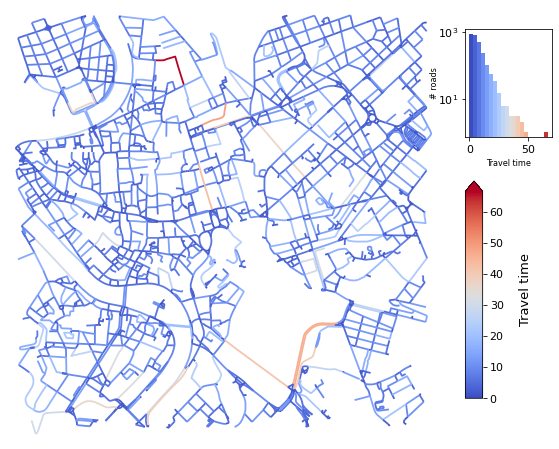

In [42]:
from mobair import plot

fig, ax = plot.plot_road_network_with_attribute(road_network_with_traveltimes, attribute_name='travel_time', 
                                                region_name=place, 
                                                tdf_with_emissions=None,
                                                normalization_factor=None,
                                                fig_size=(8, 8), 
                                                show_hist=True, n_bins=20, log_normalise=False,
                                                color_map='coolwarm', bounding_box=None,
                                                save_fig=False)